In [125]:
import json
import pandas as pd
import geopandas as gpd
from utils import *
from shapely.affinity import scale, translate
from shapely.ops import unary_union

In [126]:
# Load data, votes_dataset is the voting data and const_2024 is constituency boundaries
votes_dataset = pd.read_csv('./sim_data/votes_2024.csv')
with open('./sim_data/const_2024.geojson', 'r') as f:
    gj = json.load(f)
const_2024_gdf = gpd.GeoDataFrame.from_features(gj["features"])

# Remove special characters from constituency name fields to properly join the datasets (needed for some welsh names)
const_2024_gdf["PCON24NM"] = const_2024_gdf["PCON24NM"].str.replace(r'[^a-zA-Z]', '', regex=True)
votes_dataset["Constituency name"] = votes_dataset["Constituency name"].str.replace(r'[^a-zA-Z]', '', regex=True)

# Merge datasets on constituency name
merged_data = pd.merge(const_2024_gdf, votes_dataset, left_on="PCON24NM", right_on="Constituency name", how="outer")

In [127]:
# Plot original constituencies
constituencies = []
for i in range(len(merged_data)):
    constituencies.append(merged_data.iloc[i]["geometry"])

In [128]:
# Get NI generated cons
with open('./generated_constituencies/ni_test.geojson', 'r') as f:
    gj = json.load(f)
new_cons_gdf = gpd.GeoDataFrame.from_features(gj["features"])
list_new_cons = []
for i in range(len(new_cons_gdf)):
    list_new_cons.append(new_cons_gdf.iloc[i]["geometry"])

In [129]:
# Get NI original cons
list_country_cons = []
list_country_indexes = []
for i in range(len(merged_data)):
    if merged_data.iloc[i]["Country name"] == "Northern Ireland":
        list_country_cons.append(merged_data.iloc[i]["geometry"])
        list_country_indexes.append(i)
list_country_cons = remove_islands(list_country_cons)

In [130]:
# Convert constituency sets from lists to multipolygons
new_cons = list_to_multipolygon(list_new_cons)
country_cons = list_to_multipolygon(list_country_cons)

In [131]:
# country_cons = original geometry
# new_cons = generated geometry
# Scale new_cons to match country_cons

def get_extremes(cons):
    
    # Add all coordinates to all_coords
    all_coords = []

    for geom in cons:
        if geom.geom_type == "Polygon":
            all_coords.extend(geom.exterior.coords)
        elif geom.geom_type == "MultiPolygon":
            for poly in geom.geoms:
                all_coords.extend(poly.exterior.coords)
    
    # Find extreme points
    leftmost = min(all_coords, key=lambda p: p[0])
    rightmost = max(all_coords, key=lambda p: p[0])
    bottommost = min(all_coords, key=lambda p: p[1])
    topmost = max(all_coords, key=lambda p: p[1])

    return leftmost, rightmost, bottommost, topmost


In [132]:
def scale_geom(source_geom, target_geom):
    # Get extremes
    source_extremes = get_extremes(source_geom)
    target_extremes = get_extremes(target_geom)

    # Calculate width and heights
    source_width = source_extremes[1][0] - source_extremes[0][0]
    source_height = source_extremes[3][1] - source_extremes[2][1]
    target_width = target_extremes[1][0] - target_extremes[0][0]
    target_height = target_extremes[3][1] - target_extremes[2][1]

    # Calculate multipliers for each point
    x_mult = target_width / source_width
    y_mult = target_height / source_height

    # Scale each geometry
    scaled_geom = []
    for geom in source_geom:
        scaled_geom.append(scale(geom, xfact=x_mult, yfact=y_mult, origin=(0, 0)))
    
    current_centroid = unary_union(scaled_geom).centroid

    final_geom = []
    for geom in scaled_geom:
        final_geom.append(translate(geom, xoff=-current_centroid.x, yoff=-current_centroid.y))

    return final_geom

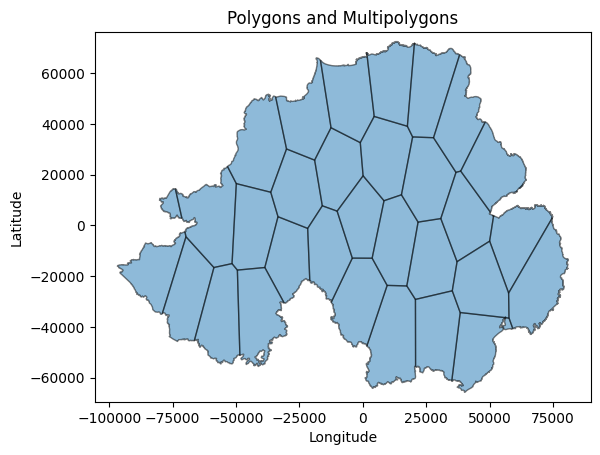

In [133]:
# Scale generated boundaries to the same size as original map
final_new_cons = scale_geom(list_new_cons, list_country_cons)
plot_map(final_new_cons)

In [134]:
# Center original map around origin

# Get centroid
country_cons_centroid = unary_union(list_country_cons).centroid
dx = -country_cons_centroid.x
dy = -country_cons_centroid.y

# Translate to origin centre
final_country_cons = []
for geom in list_country_cons:
    final_country_cons.append(translate(geom, xoff=dx, yoff=dy))
# final_country_cons = MultiPolygon([
#     translate(polygon, xoff=dx, yoff=dy) for polygon in country_cons.geoms
# ])

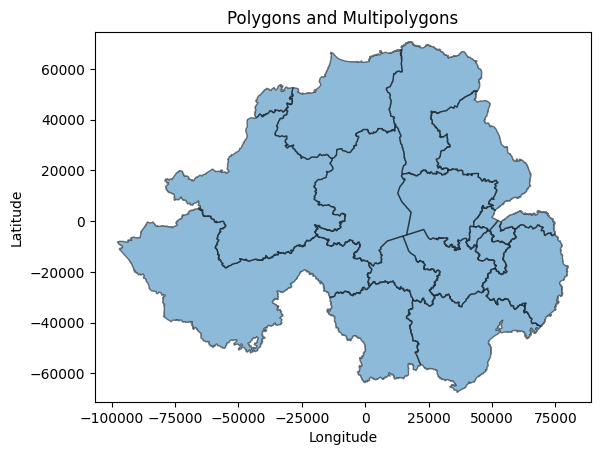

In [135]:
plot_map(final_country_cons)

In [136]:
print(get_extremes(final_new_cons))
print(get_extremes(final_country_cons))

((-96830.14829342312, -16065.193684695289), (80969.21650657669, -13527.179999404587), (40153.47873160709, -65791.27279277984), (13398.696614219225, 72511.20210721996))
((-97735.57486322656, -8352.783999480656), (80063.78993677322, -18001.441799480584), (36301.300136773236, -67474.61209948262), (17504.200636773225, 70827.86280051735))


In [137]:
# [i] is a list of (country_con index, multiplier) tuples for new_con i
# Multiply vote count of the country_con
weighted_mapping = [[] for _ in range(len(final_new_cons))]

for i in range(len(final_new_cons)):

    new_con = final_new_cons[i]

    for j in range(len(final_country_cons)):

        country_con = final_country_cons[j]

        if new_con.overlaps(country_con):
            
            intersect = new_con.intersection(country_con)
            multiplier = intersect.area/country_con.area
            weighted_mapping[i].append((j, multiplier))

In [138]:
print(merged_data.columns[28])
print(merged_data.columns[39])

Con
APNI


In [149]:
# Generate simulated voting results
# index corresponds to index in final_new_cons
results_df = pd.DataFrame(columns=["Con","Lab","LD","RUK","Green","SNP","PC","DUP","SF","SDLP","UUP","APNI"])
for i in range(len(final_new_cons)):
    for cci, mult in weighted_mapping[i]:
        new_row = []
        for j in range(28, 40):
            val = merged_data.iloc[cci, j]
            new_row.append(val*mult)
        results_df.loc[i] = new_row

print(results_df)


            Con          Lab           LD           RUK        Green  \
0     30.932620   110.120126     9.976212     62.105630    17.541447   
1   2680.050168  1956.313584   295.798255   1669.111177   294.281340   
2    786.530756  2800.049492   253.667405   1579.173980   446.030356   
3     22.069129    78.566099     7.117609     44.309766    12.515088   
4    904.645844  3220.539206   291.761208   1816.322079   513.011735   
5    942.870586  3356.619286   304.089234   1893.068623   534.688440   
6   7640.927526  3397.279808  3426.800232   2566.887657  1915.354543   
7    362.197160  1289.421888   116.813758    727.209109   205.396835   
8   1048.582390  1186.936471   190.149369    788.672700   338.691412   
9   2578.613810  1882.269700   284.602681   1605.937523   283.143180   
10   809.911280  2883.284155   261.207958   1626.116727   459.289116   
11  1647.061931  1864.381754   298.677329   1238.808503   531.999904   
12     7.672062    27.312542     2.474350     15.403748     4.35